## Objetivo: Análise Exploratória dos dados sobre filmes e cast de filmes disponibilizados na plataforma Netflix.

Dados: https://www.kaggle.com/datasets/victorsoeiro/netflix-tv-shows-and-movies

In [0]:
!python -m pip install --upgrade pip
!python -m pip install graphframes

     |████████████████████████████████| 2.1 MB 6.5 MB/s 
  Attempting uninstall: pip
    Found existing installation: pip 21.2.4
    Uninstalling pip-21.2.4:
      Successfully uninstalled pip-21.2.4


In [0]:
# Importando bibliotecas
import pandas as pd
import numpy as np
import warnings
import seaborn as sns
from matplotlib import pyplot as plt
from pyspark.sql.functions import *
from pyspark.sql.types import IntegerType
from pyspark.ml.feature import Bucketizer
from graphframes import *
from graphframes import GraphFrame

%matplotlib inline
warnings.filterwarnings('ignore')
np.random.seed(0)

### Definição de Funções

In [0]:
# Habilita Arrow-based columnar data transfers
spark.conf.set("spark.sql.execution.arrow.enabled", "true")

In [0]:
# Transforma blank string em None
def blank_as_null(x):
    return when(col(x) != "", col(x)).otherwise(None)

## Análise exploratória dos dados

### Dois arquivos disponilizados: títulos e créditos

In [0]:
# Carregando os dados
data_titles = spark.read.csv('dbfs:/FileStore/titles.csv', header=True, multiLine=True)
data_credits = spark.read.csv('dbfs:/FileStore/credits.csv', header=True, multiLine=True)

## Visualização dos dados

#### Checando e comparando "missing values"

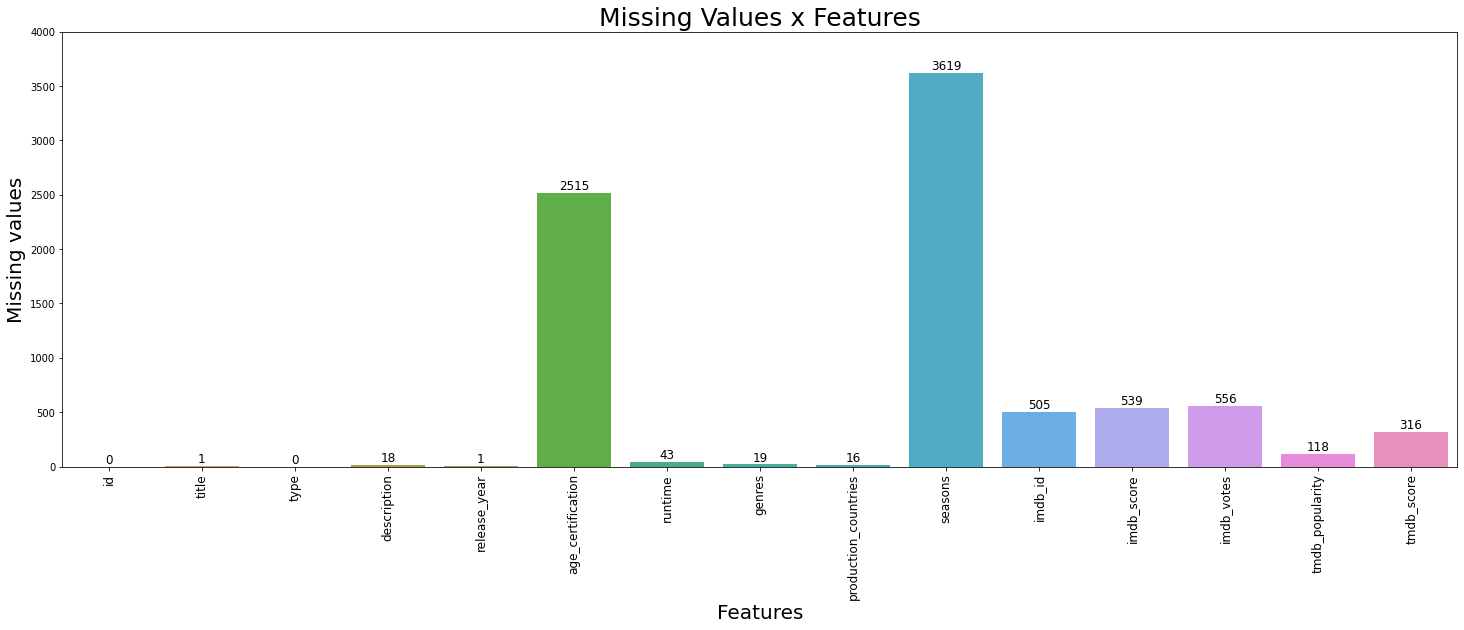

In [0]:
qtd_null = data_titles.select([count(when(isnan(c) | col(c).isNull(), c)).alias(c) for c in data_titles.columns])
x = list(qtd_null.columns)
y = list(list(qtd_null.collect()[0]))

ax = sns.barplot(x,y)
plt.title('Missing Values x Features', fontsize=25)
plt.xlabel('Features', fontsize=20)
plt.ylabel('Missing values', fontsize=20)
plt.xticks(rotation='vertical', fontsize=12)
fig = plt.gcf()
fig.set_size_inches(25, 8)
for p in ax.patches:
    ax.annotate(f"{p.get_height():.0f}", (p.get_x() + p.get_width() / 2., p.get_height()),
                ha='center', va='center', xytext =(0, 7), textcoords='offset points', fontsize=12)
plt.ylim(0, 4000)
plt.show();

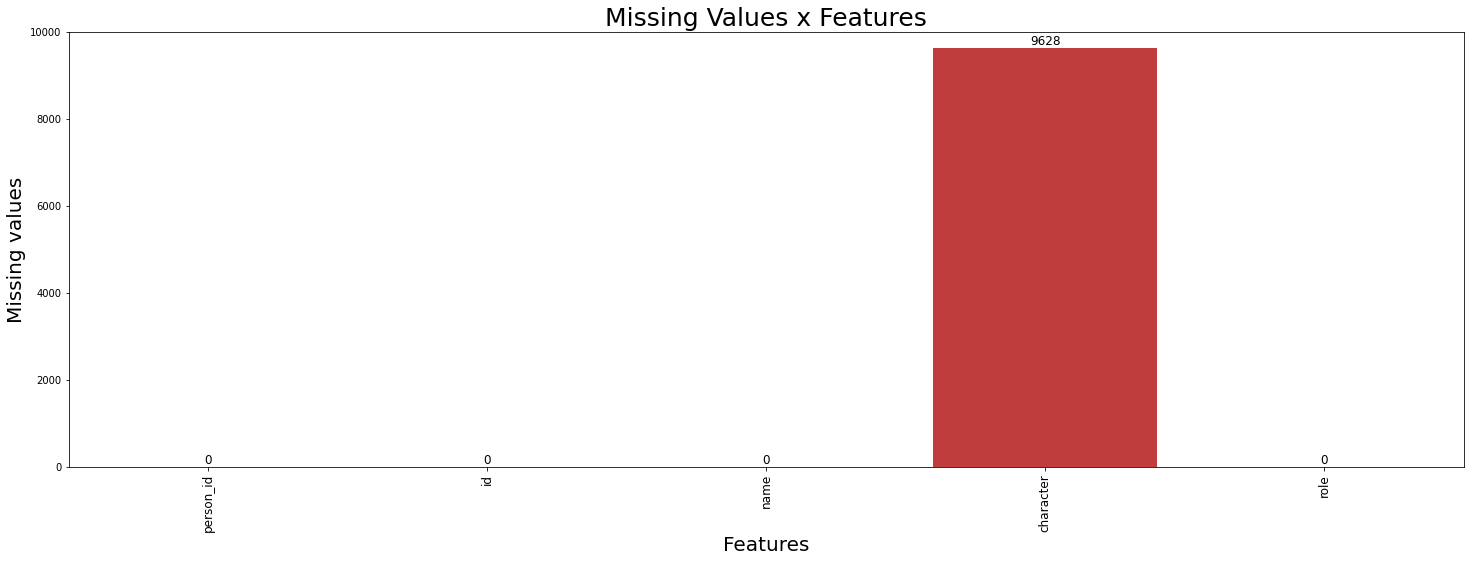

In [0]:
qtd_null = data_credits.select([count(when(isnan(c) | col(c).isNull(), c)).alias(c) for c in data_credits.columns])
x = list(qtd_null.columns)
y = list(list(qtd_null.collect()[0]))

ax = sns.barplot(x, y)
plt.title('Missing Values x Features', fontsize=25)
plt.xlabel('Features', fontsize=20)
plt.ylabel('Missing values', fontsize=20)
plt.xticks(rotation='vertical', fontsize=12)
fig = plt.gcf()
fig.set_size_inches(25, 8)
for p in ax.patches:
    ax.annotate(f"{p.get_height():.0f}", (p.get_x() + p.get_width() / 2., p.get_height()),
                ha='center', va='center', xytext =(0, 7), textcoords='offset points', fontsize=12)
plt.ylim(0, 10000)
plt.show();

#### Distribuição dos filmes por década de lançamento

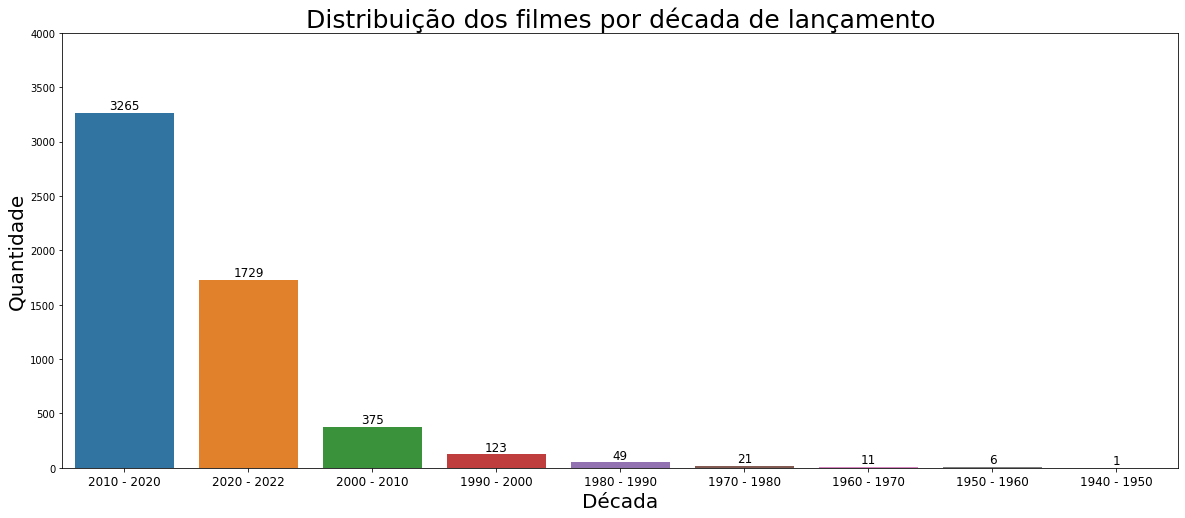

In [0]:
df_dec = data_titles.alias('df_dec')
df_dec = df_dec.withColumn('release_year', blank_as_null('release_year'))
df_dec = df_dec.na.drop(subset=['release_year'])
df_dec = df_dec.withColumn("release_year", df_dec["release_year"].cast(IntegerType()))


splits=[-float('inf'),1950,1960,1970,1980,1990,2000,2010,2020,2030,float('inf')]
labels = ['1940 - 1950','1950 - 1960','1960 - 1970','1970 - 1980','1980 - 1990','1990 - 2000','2000 - 2010','2010 - 2020','2020 - 2022']
bucketizer = Bucketizer(splits=splits,
                        inputCol='release_year',
                        outputCol='split')

df_dec = bucketizer.transform(df_dec)
label_array = array(*(lit(label) for label in labels))
df_dec = df_dec.withColumn("release_interval", label_array.getItem(col("split").cast("integer")))

df_dec = df_dec.groupBy('release_interval').count().orderBy('count', ascending=False)
x = list(df_dec.select('release_interval').toPandas()['release_interval'])
y = list(df_dec.select('count').toPandas()['count'])

ax = sns.barplot(x,y) ### Utlilizei o barplot, pois ficou similar ao histograma
plt.xlabel("Década", fontsize=20)
plt.ylabel("Quantidade", fontsize=20)
plt.xticks(fontsize=12)
fig = plt.gcf()
fig.set_size_inches(20, 8)
for p in ax.patches:
    ax.annotate(f"{p.get_height():.0f}", (p.get_x() + p.get_width() / 2., p.get_height()),
                ha='center', va='center', xytext =(0, 7), textcoords='offset points', fontsize=12)
plt.title("Distribuição dos filmes por década de lançamento", fontsize=25)
plt.ylim(0, 4000)
plt.show();

#### Visualizando os 10 gêneros mais frequentes

In [0]:
# Identificar o gênero principal de cada filme (inserir coluna movie_genre)
data_titles = data_titles.withColumn('genres', regexp_replace('genres', "\[?", ""))
data_titles = data_titles.withColumn('genres', regexp_replace('genres', "'", ""))
data_titles = data_titles.withColumn('genres', regexp_replace('genres', "\]?", ""))
data_titles = data_titles.withColumn('genres', blank_as_null('genres'))
data_titles = data_titles.na.drop(subset=['genres'])

data_titles = data_titles.withColumn('movie_genre', substring_index(col('genres'),',', 1))
data_titles = data_titles.withColumn('movie_genre', blank_as_null('movie_genre'))
data_titles = data_titles.na.drop(subset=['movie_genre'])

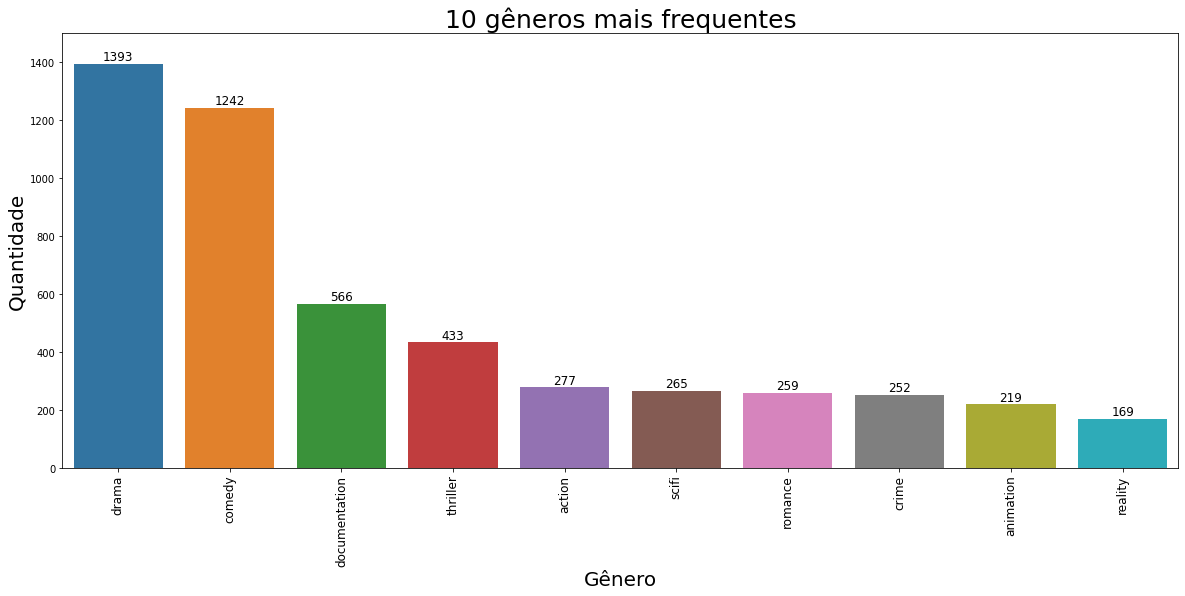

In [0]:
dommoviegenre = data_titles.groupBy('movie_genre').count().orderBy('count', ascending=False)
x = list(dommoviegenre.select('movie_genre').toPandas()['movie_genre'])
y = list(dommoviegenre.select('count').toPandas()['count'])

ax = sns.barplot(x[0:10],y[0:10])
plt.xlabel("Gênero", fontsize=20)
plt.ylabel("Quantidade", fontsize=20)
plt.xticks(rotation='vertical', fontsize=12)
fig = plt.gcf()
fig.set_size_inches(20, 8)
for p in ax.patches:
    ax.annotate(f"{p.get_height():.0f}", (p.get_x() + p.get_width() / 2., p.get_height()),
                ha='center', va='center', xytext =(0, 7), textcoords='offset points', fontsize=12)
plt.title("10 gêneros mais frequentes", fontsize=25)
plt.ylim(0, 1500)
plt.show();


#### Top 20 de países produtores de filmes

In [0]:
# Identificar o país principal de cada filme
data_titles = data_titles.withColumn('production_countries', regexp_replace('production_countries', "\[?", ""))
data_titles = data_titles.withColumn('production_countries', regexp_replace('production_countries', "'", ""))
data_titles = data_titles.withColumn('production_countries', regexp_replace('production_countries', "\]?", ""))
data_titles = data_titles.withColumn('production_countries', blank_as_null('production_countries'))
data_titles = data_titles.na.drop(subset=['production_countries'])

data_titles = data_titles.withColumn('country', substring_index(col('production_countries'),',', 1))
data_titles = data_titles.withColumn('country', blank_as_null('country'))
data_titles = data_titles.na.drop(subset=['country'])

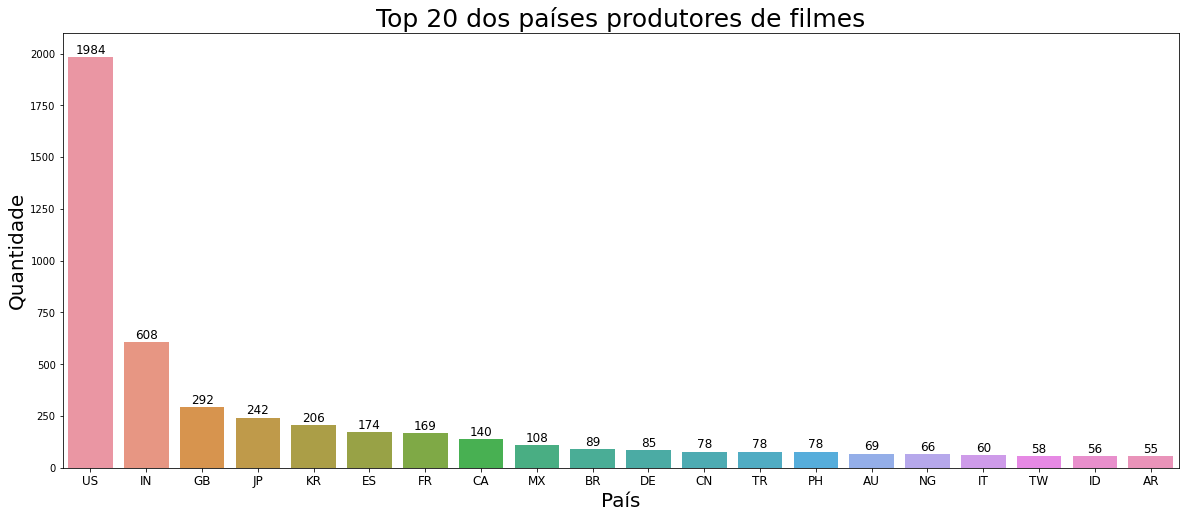

In [0]:
dommcountry = data_titles.groupBy('country').count().orderBy('count', ascending=False)
x = list(dommcountry.select('country').toPandas()['country'])
y = list(dommcountry.select('count').toPandas()['count'])

ax = sns.barplot(x[0:20],y[0:20])
plt.xlabel("País", fontsize=20)
plt.ylabel("Quantidade", fontsize=20)
plt.xticks(fontsize=12)
fig = plt.gcf()
fig.set_size_inches(20, 8)
for p in ax.patches:
    ax.annotate(f"{p.get_height():.0f}", (p.get_x() + p.get_width() / 2., p.get_height()),
                ha='center', va='center', xytext =(0, 7), textcoords='offset points', fontsize=12)
plt.title("Top 20 dos países produtores de filmes", fontsize=25)
plt.ylim(0, 2100)
plt.show();

#### Top 20 de atores participantes de filmes na Netflix

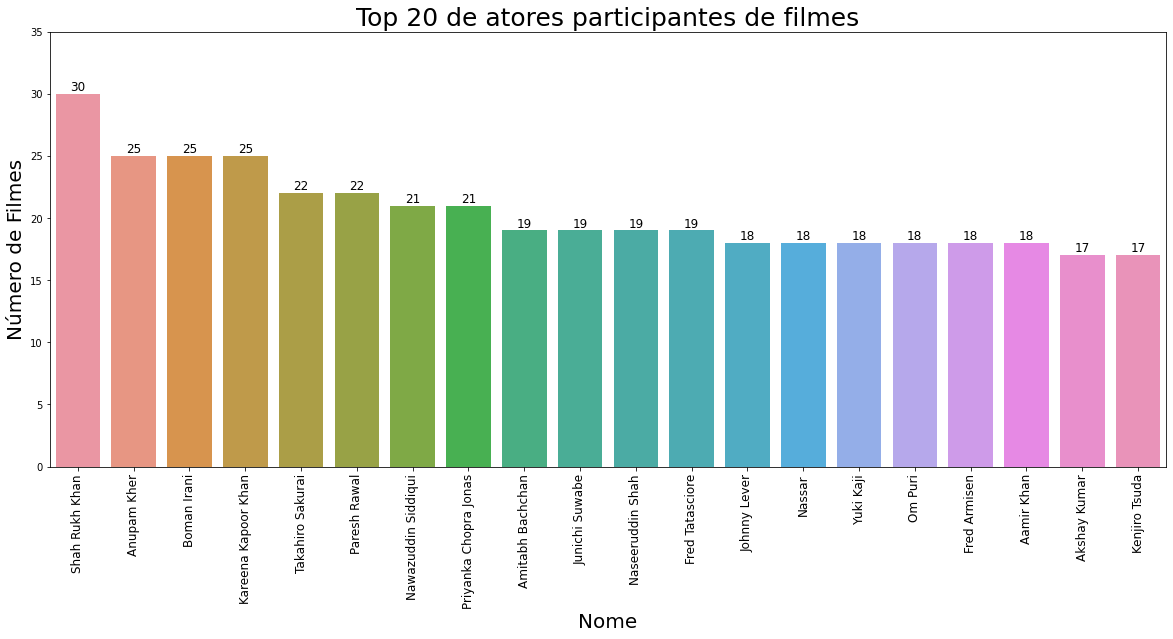

In [0]:
df_dir = data_credits.alias('df_dir')
df_dir = df_dir[df_dir['role'] != 'DIRECTOR']
df_dir = df_dir.groupBy('name').count().orderBy('count', ascending=False)
x = list(df_dir.select('name').toPandas()['name'])
y = list(df_dir.select('count').toPandas()['count'])

ax = sns.barplot(x[0:20],y[0:20])
plt.xlabel("Nome", fontsize=20)
plt.ylabel("Número de Filmes", fontsize=20)
plt.xticks(rotation='vertical', fontsize=12)
fig = plt.gcf()
fig.set_size_inches(20, 8)
for p in ax.patches:
    ax.annotate(f"{p.get_height():.0f}", (p.get_x() + p.get_width() / 2., p.get_height()),
                ha='center', va='center', xytext =(0, 7), textcoords='offset points', fontsize=12)
plt.title("Top 20 de atores participantes de filmes", fontsize=25)
plt.ylim(0, 35)
plt.show();

#### Top 20 de diretores participantes de filmes

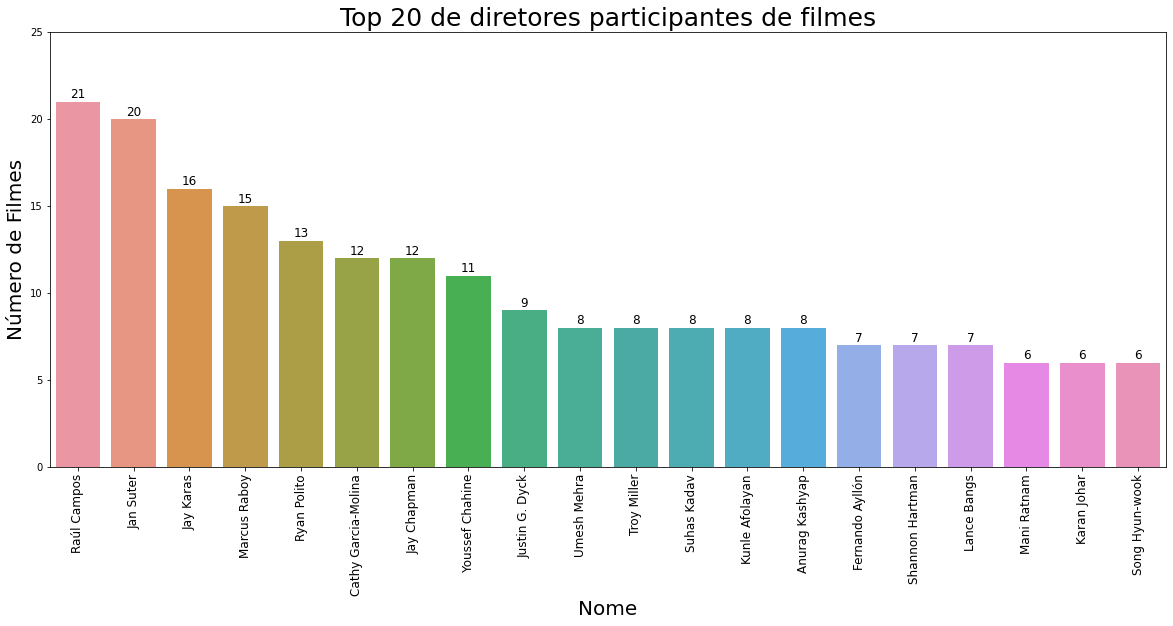

In [0]:
df_dir = data_credits.alias('df_dir')
df_dir = df_dir[df_dir['role'] != 'ACTOR']
df_dir = df_dir.groupBy('name').count().orderBy('count', ascending=False)
x = list(df_dir.select('name').toPandas()['name'])
y = list(df_dir.select('count').toPandas()['count'])

ax = sns.barplot(x[0:20],y[0:20])
plt.xlabel("Nome", fontsize=20)
plt.ylabel("Número de Filmes", fontsize=20)
plt.xticks(rotation='vertical', fontsize=12)
fig = plt.gcf()
fig.set_size_inches(20, 8)
for p in ax.patches:
    ax.annotate(f"{p.get_height():.0f}", (p.get_x() + p.get_width() / 2., p.get_height()),
                ha='center', va='center', xytext =(0, 7), textcoords='offset points', fontsize=12)
plt.title("Top 20 de diretores participantes de filmes", fontsize=25)
plt.ylim(0, 25)
plt.show();

#### Análise de relacionamentos (Network) entre atores e diretores dos filmes disponibilizados na plataforma Netflix

In [0]:
# Criação de lista com os Edges - Edge DataFrame
df_actor = data_credits[data_credits['role'] != 'DIRECTOR']
df_director = data_credits[data_credits['role'] == 'DIRECTOR']
df_director = df_director.withColumnRenamed('person_id', 'person_id_r') \
                         .withColumnRenamed('name', 'name_r') \
                         .withColumnRenamed('role', 'role_r')
df_join = df_actor.join(df_director,[df_actor.id == df_director.id], how = 'inner')
edges = list(zip(list(df_join.select('person_id').toPandas()['person_id']),list(df_join.select('person_id_r').toPandas()['person_id_r'])))

columns = ['src', 'dst']
df_edges = spark.createDataFrame(edges, columns)

In [0]:
# Criação de lista com os Vértices - Vertex DataFrame
vertex = list(zip(list(data_credits.select('person_id').toPandas()['person_id']),list(data_credits.select('name').toPandas()['name'])))
columns = ['id', 'name']
df_vertex = spark.createDataFrame(vertex, columns)

In [0]:
g = GraphFrame(df_vertex,df_edges)

---------------------------------------------------------------------------
Py4JJavaError                             Traceback (most recent call last)
<command-4160744775078944> in <cell line: 1>()
----> 1 g = GraphFrame(df_vertex,df_edges)

/local_disk0/.ephemeral_nfs/envs/pythonEnv-6fcc268f-0fba-4b97-b5e0-fabec76425f1/lib/python3.9/site-packages/graphframes/graphframe.py in __init__(self, v, e)
     63         self._sqlContext = v.sql_ctx
     64         self._sc = self._sqlContext._sc
---> 65         self._jvm_gf_api = _java_api(self._sc)
     66 
     67         self.ID = self._jvm_gf_api.ID()

/local_disk0/.ephemeral_nfs/envs/pythonEnv-6fcc268f-0fba-4b97-b5e0-fabec76425f1/lib/python3.9/site-packages/graphframes/graphframe.py in _java_api(jsc)
     36 def _java_api(jsc):
     37     javaClassName = "org.graphframes.GraphFramePythonAPI"
---> 38     return jsc._jvm.Thread.currentThread().getContextClassLoader().loadClass(javaClassName) \
     39             .newInstance()
     40 

